# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
import sklearn.datasets


def my_split(x, frac):
    return x[0 : int(round(x.shape[0]-(x.shape[0]*frac)-1))], x[- int(round(x.shape[0]*frac)) :]

X, y = sklearn.datasets.load_boston(return_X_y = True)

X_train, X_test = my_split(X, 0.25)
y_train, y_test = my_split(y, 0.25)

print X.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape

(506, 13) (379, 13) (127, 13) (379,) (127,)


t = np.array([1,2,3,4,5,6,7,8,9,10]) #np.ones(10)
#t[-5:]
my_split(t, 0.25)

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

Компоненты вектора сдвигов s, фактически, являются теми значениями, которые на объектах обучающей
выборки должен принимать новый алгоритм b N (x), чтобы минимизировать ошибку строящейся композиции.

In [2]:
# ? думаю как то так
def L_anti_gradient(a_compose_x, y):
    return -(a_compose_x - y)

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

import numpy as np
a1 = np.ones(3)
a2 = np.ones(3)
#a1 = a1 * 2
a2 += (a1 * 2)

print a2


In [3]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] 
                for algo, coeff in zip(base_algorithms_list, coefficients_list)]) 
                    for x in X]

base_algorithms_list = []
coefficients_list = []

#s = np.copy(y_train)
#s.fill(np.average(y_train))
s = np.zeros(X_train.shape[0]) # initial zeros for shift vector
a_x = np.zeros(y_train.shape[0]) # current compose tree results 
step = 0.9
for _ in range(50):
    dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
    bn = dtr.fit(X=X_train, y=s)
    predict = bn.predict(X_train)
    #predict = gbm_predict(X_train)
    base_algorithms_list.append(bn)
    coefficients_list.append(step)
    a_x += (step * predict)
    #print a_x
    s = L_anti_gradient(a_x, y_train)
    #s = (y_train - a_x)



In [4]:
from sklearn.metrics import mean_squared_error

#print a_x.shape, len(base_algorithms_list), len(coefficients_list) 
y_pred = gbm_predict(X_test)

answer1 = (mean_squared_error(y_test, y_pred)) ** 0.5
print answer1

for i in range(len(y_test)):
    print y_pred[i], y_test[i]


5.47676640788
14.078745247 10.2
15.4880976115 10.4
14.13632885 10.9
15.7064544345 11.3
15.1146862828 12.3
17.0787749535 8.8
15.3631749426 7.2
15.3729041713 10.5
17.7415460401 7.4
15.4137905544 10.2
14.4572274408 11.5
15.774205085 15.1
18.3124522955 23.2
15.4141336491 9.7
21.6591141543 13.8
16.375481611 12.7
14.9991717157 13.1
14.063418423 12.5
15.1561422744 8.5
16.0665248014 5.0
17.7796344988 6.3
15.7366563619 5.6
13.8771683882 7.2
14.0740418206 12.1
15.4424048415 8.3
16.8705777968 8.5
16.2998208037 5.0
14.1027131994 11.9
21.4900972017 27.9
14.901850611 17.2
13.8817201666 27.5
21.8635510503 15.0
13.1161433024 17.2
14.9037800586 17.9
14.9499040043 16.3
14.8743231648 7.0
13.1473719427 7.2
13.7630322072 7.5
17.1519305656 10.4
15.0698139546 8.8
16.2580113318 8.4
19.3348561756 16.7
19.77509599 14.2
22.1489304942 20.8
15.8342418844 13.4
19.7699758041 11.7
15.0990252378 8.3
23.5044005151 10.2
22.9187369305 10.9
16.8446344021 11.0
13.0454600079 9.5
16.1133748811 14.5
14.0291511228 14.1
25.8378

def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithm, coeffs)]) for x in X]

base_algorithm=[]
coeffs=[]
s = y_train
for i in range(50):
    clf=DecisionTreeRegressor(max_depth=5, random_state=42)
    clf.fit(X=X_train, y=s)
    base_algorithm.append(clf)
    coeffs.append(0.9)
    s=y_train-gbm_predict(X_train)
    
error=mean_squared_error(y_test, gbm_predict(X_test))
rmse=error**0.5
print rmse


## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [5]:
base_algorithms_list = []
coefficients_list = []

s = np.zeros(X_train.shape[0]) # initial zeros for shift vector
a_x = np.zeros(y_train.shape[0]) # current compose tree results 

for i in range(50):
    step = 0.9/(1.0+i+1) 
    dtr = DecisionTreeRegressor(max_depth=5, random_state=42)
    bn = dtr.fit(X=X_train, y=s)
    predict = bn.predict(X_train)
    base_algorithms_list.append(bn)
    coefficients_list.append(step)
    a_x += (step * predict)
    s = L_anti_gradient(a_x, y_train)
    


In [6]:
y_pred = gbm_predict(X_test)

answer1 = (mean_squared_error(y_test, y_pred)) ** 0.5
print answer1

for i in range(len(y_test)):
    print y_pred[i], y_test[i]


4.49731975575
14.0550835319 10.2
14.4192013339 10.4
13.8266468326 10.9
13.9356743213 11.3
13.9356743213 12.3
15.3156960485 8.8
13.9009512424 7.2
13.8198411964 10.5
14.7589946152 7.4
14.6624906942 10.2
13.9356743213 11.5
14.9460211925 15.1
15.1538117875 23.2
13.9356743213 9.7
17.2265055827 13.8
14.8832797798 12.7
15.5318818297 13.1
16.9829595958 12.5
14.738672593 8.5
13.8198411964 5.0
16.8091395344 6.3
13.5858952643 5.6
13.6952193587 7.2
14.5464302116 12.1
13.9929215589 8.3
15.105788335 8.5
14.6003153094 5.0
14.4019668659 11.9
21.1800482618 27.9
14.8267750436 17.2
17.6378670849 27.5
30.794752994 15.0
13.6290689722 17.2
14.1327803462 17.9
14.9651323272 16.3
14.1327803462 7.0
13.7172461746 7.2
15.5189813826 7.5
14.8466294163 10.4
14.0327588019 8.8
16.2355648669 8.4
17.6139403157 16.7
17.6827539154 14.2
18.3337934588 20.8
14.2451456642 13.4
15.8996853154 11.7
13.4308592264 8.3
18.0131192465 10.2
18.2177170137 10.9
15.7874659651 11.0
13.7172461746 9.5
14.7173155758 14.5
18.1122536743 14.1
2

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

In [7]:
from sklearn import ensemble , cross_validation, learning_curve, metrics 

import numpy as np
import pandas as pd
import xgboost as xgb
%pylab inline

/home/sigor/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/sigor/anaconda2/lib/python2.7/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/home/sigor/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
steps = np.array(range(-90, -1))*-0.01
steps

array([ 0.9 ,  0.89,  0.88,  0.87,  0.86,  0.85,  0.84,  0.83,  0.82,
        0.81,  0.8 ,  0.79,  0.78,  0.77,  0.76,  0.75,  0.74,  0.73,
        0.72,  0.71,  0.7 ,  0.69,  0.68,  0.67,  0.66,  0.65,  0.64,
        0.63,  0.62,  0.61,  0.6 ,  0.59,  0.58,  0.57,  0.56,  0.55,
        0.54,  0.53,  0.52,  0.51,  0.5 ,  0.49,  0.48,  0.47,  0.46,
        0.45,  0.44,  0.43,  0.42,  0.41,  0.4 ,  0.39,  0.38,  0.37,
        0.36,  0.35,  0.34,  0.33,  0.32,  0.31,  0.3 ,  0.29,  0.28,
        0.27,  0.26,  0.25,  0.24,  0.23,  0.22,  0.21,  0.2 ,  0.19,
        0.18,  0.17,  0.16,  0.15,  0.14,  0.13,  0.12,  0.11,  0.1 ,
        0.09,  0.08,  0.07,  0.06,  0.05,  0.04,  0.03,  0.02])

http://xgboost.readthedocs.io/en/latest/python/python_api.html

In [10]:
%%time
xgb_scoring = []
trees = 50
for step in steps:
    estimator = xgb.XGBRegressor(n_estimators=trees, learning_rate=step, max_depth=5, min_child_weight=3)
    score = cross_validation.cross_val_score(estimator, X, y, scoring='r2', cv=3)
    xgb_scoring.append(score)
xgb_scoring = np.asmatrix(xgb_scoring)    
    

CPU times: user 14.8 s, sys: 208 ms, total: 15 s
Wall time: 3.87 s


In [17]:
n_trees = [1] + range(10, 155, 5) 
n_trees

[1,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100,
 105,
 110,
 115,
 120,
 125,
 130,
 135,
 140,
 145,
 150]

In [19]:
%%time
xgb_scoring_2 = []
for tree in trees:
    estimator = xgb.XGBRegressor(n_estimators=tree, learning_rate=0.01, max_depth=5, min_child_weight=3)
    score = cross_validation.cross_val_score(estimator, X, y, scoring='r2', cv=3)
    xgb_scoring_2.append(score)
xgb_scoring_2 = np.asmatrix(xgb_scoring)    


TypeError: 'int' object is not iterable

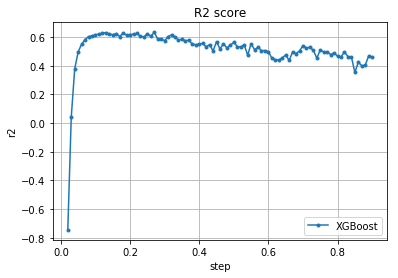

In [13]:
pylab.plot(steps, xgb_scoring.mean(axis = 1), marker='.', label='XGBoost')
pylab.grid(True)
pylab.xlabel('step')
pylab.ylabel('r2')
pylab.title('R2 score')
pylab.legend(loc='lower right')

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.